In [31]:
import os
import pandas as pd 
import datetime as dt
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import yfinance as yf
from pdb import set_trace as keyboard
import numpy as np
import matplotlib.pyplot as plt

In [32]:
stockTicker = 'itsa4'

preferentialOrUnit = ['4', '5', '6', '11']
if stockTicker[-1] in preferentialOrUnit or stockTicker[-2:] in preferentialOrUnit:
    stockType = 'Preferencial'
    if stockTicker[-2:] == '11':
        stockTicker = stockTicker.replace('11', '4')
else: 
    stockType = 'Ordinária'
    
nYears = 3
endDate = dt.datetime(2019, 8, 15)
startDate = endDate - dt.timedelta(days=int(365*nYears))
startDate = dt.datetime(2019, 1, 21)


stockTicker, stockType

('itsa4', 'Preferencial')

In [33]:
yf.pdr_override()

In [34]:
endDate_str = endDate.strftime("%Y-%m-%d")
startDate_str = startDate.strftime("%Y-%m-%d")
stockDF = pdr.get_data_yahoo(stockTicker + '.SA', start=startDate_str, end=endDate_str)[::-1]['Close']
stockDF_priceEv = stockDF/stockDF.iloc[-1]
#stockDF.head(5)
mask = (stockDF.index < dt.datetime(2016, 11, 1)) & (stockDF.index > dt.datetime(2016, 9, 1))
#stockDF[mask]
#stockDF.index
stockDF.tail()

[*********************100%***********************]  1 of 1 downloaded


Date
2019-01-28    13.49
2019-01-24    13.20
2019-01-23    12.99
2019-01-22    12.82
2019-01-21    12.88
Name: Close, dtype: float64

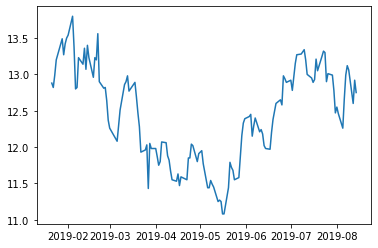

In [35]:
plt.plot(stockDF)

In [36]:
import requests
from bs4 import BeautifulSoup
req = requests.get('https://br.advfn.com/bolsa-de-valores/bovespa/%s/dividendos' % stockTicker)
if req.status_code == 200:
    print('Requisição bem sucedida!')
    content = req.content

Requisição bem sucedida!


In [37]:
soup = BeautifulSoup(content, 'html.parser')

In [38]:
table = []
monthDict={'Jan':1, 'Fev':2, 'Mar':3, 'Abr':4, 'Mai':5, 'Jun':6, 'Jul':7, 'Ago':8, 'Set':9, 'Out':10, 'Nov':11, 'Dez':12}

contents_str = str(soup.find_all(class_="Element TableElement DividendsTableElement")[0]).split('</tr>')
for i in contents_str[1:]:
    
    try:
        elements = i.split('"String Column2">')
        temp = elements[1].split('</td><td class="String Column3">Proventos em dinheiro</td><td class="String Column4">')
        
        day, month, year = temp[0].split(' ')
        paymentDate = dt.datetime(int(year), monthDict[month], int(day))


        temp2 = temp[1].split('</td><td class="Numeric Column5 ColumnLast"')

        stockType = temp2[0]

        dividend = float(temp2[1].split('>')[1].split('</td')[0].replace(',', '.'))
        #keyboard()

        table.append([paymentDate, stockType, dividend])
    except:
        continue ##########Check
    
dividends_df = pd.DataFrame(np.array(table), columns=['PaymentDate', 'StockType', 'Dividend'])
dividends_df_stocktype = dividends_df[dividends_df['StockType'] == stockType]

#dividends_df[dividends_df['StockType'] == 'Ordinária']

In [39]:
dividends_df_unique = dividends_df.drop_duplicates('PaymentDate', keep='first')
dividends_df_unique = dividends_df_unique.set_index(['PaymentDate'])
dividends_df_unique.head(10)

,StockType,Dividend
PaymentDate,,
2020-01-02,Preferencial,0.02
2019-07-01,Ordinária,0.02
2019-03-07,Preferencial,0.3111
2019-04-30,Ordinária,0.0081
2018-08-30,Ordinária,0.2088
2019-01-02,Preferencial,0.015
2018-07-02,Ordinária,0.015
2018-03-07,Ordinária,0.29525
2018-04-02,Ordinária,0.015


In [40]:
evolution = [0.]
stockDates = [pd.Timestamp(i).to_pydatetime() for i in stockDF.index][::-1]

lastPrice  = stockDF.iloc[-1]
addDiv = False
for date in stockDF.index[::-1][1:]:
    closePrice = stockDF[date]
    if date in dividends_df_unique.index:
        addDiv = True
        dividendReceived = dividends_df_unique.loc[date]['Dividend']
        
    patrimonialDiff = (closePrice - lastPrice)
    if addDiv:
        patrimonialDiff += dividendReceived
    
    evolution.append((1. + evolution[-1]) * (1. + patrimonialDiff / lastPrice) - 1.)
    addDiv = False
    lastPrice  = closePrice

2019-01-21 2019-08-15

Without reinv.: -1.0%; With reinv.: 1.7%


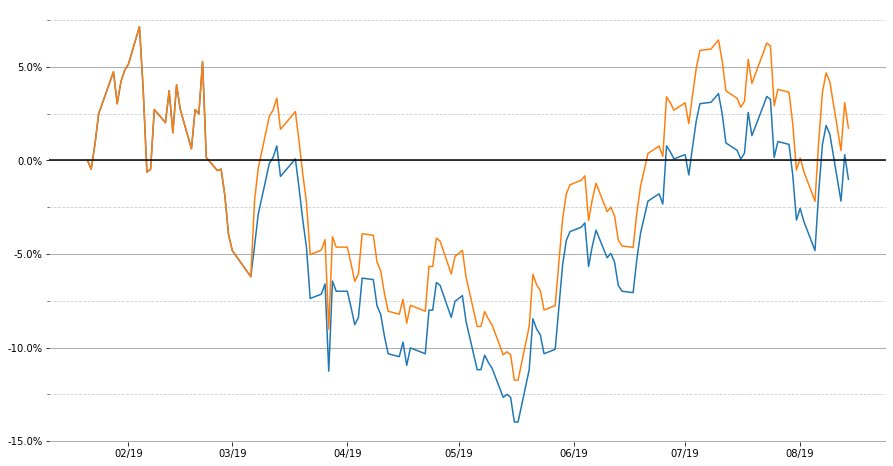

In [41]:
print(startDate_str, endDate_str) 
print('\nWithout reinv.: %.1f%%; With reinv.: %.1f%%' % (100.*(stockDF_priceEv.values[::-1][-1]-1), 100.*evolution[-1]))

import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
import matplotlib.dates as mdates

@ticker.FuncFormatter
def formatterPerctg(x, pos):
    x *= 100.
    return "%.1f%%" % x

fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(stockDates, stockDF_priceEv.values[::-1] - 1.)
ax.plot(stockDates, evolution)
ax.axhline(0, c='k')

ax.set_facecolor('xkcd:white')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.yaxis.grid(b=True, which='major', color='k', linestyle='-', alpha=.4)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(b=True, which='minor', color='k', linestyle='--', alpha=.2) 

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

ax.yaxis.set_major_formatter(formatterPerctg)